### PART 0:

### Look at the structure of the hdf5 file

In [84]:
import h5py

def print_mat_structure(filename, root="data_avg"):
    """
    Print structure of a MATLAB v7.3 MAT file in a MATLAB-like format.
    """

    def _print_item(name, obj, indent=0):
        pad = "  " * indent

        if isinstance(obj, h5py.Group):
            print(f"{pad}{name.split('/')[-1]}")
            for key in obj.keys():
                _print_item(f"{name}/{key}", obj[key], indent + 1)

        elif isinstance(obj, h5py.Dataset):
            shape = obj.shape
            dtype = obj.dtype
            print(f"{pad}{name.split('/')[-1]} : {dtype} {shape}")

    with h5py.File(filename, "r") as f:
        if root not in f:
            raise ValueError(f"Root '{root}' not found in file")

        _print_item(root, f[root], indent=0)


# Example usage
if __name__ == "__main__":
    filename = "FolgerDeep_20140101_20260101_averaged.mat"
    print_mat_structure(filename)


data_avg
  hr_01
    ch_120kHz
      ABC : float64 (2, 105192)
      CM : float64 (2, 105192)
      UL : float64 (2, 105192)
    ch_120kHz_krill
      ABC : float64 (2, 105192)
      CM : float64 (2, 105192)
      UL : float64 (2, 105192)
    ch_120kHz_krill2
      ABC : float64 (2, 105192)
      CM : float64 (2, 105192)
      UL : float64 (2, 105192)
    ch_200kHz
      ABC : float64 (2, 105192)
      CM : float64 (2, 105192)
      UL : float64 (2, 105192)
    ch_38kHz
      ABC : float64 (2, 105192)
      CM : float64 (2, 105192)
      UL : float64 (2, 105192)
    ch_38kHz_fish
      ABC : float64 (2, 105192)
      CM : float64 (2, 105192)
      UL : float64 (2, 105192)
    depth_press : float64 (1, 105192)
    label : uint32 (1, 6)
    surface_cutoff : float64 (1, 105192)
    surface_cutoff_bins : float64 (1, 105192)
    temperature : float64 (1, 105192)
    tiltX : float64 (1, 105192)
    tiltY : float64 (1, 105192)
    time : float64 (1, 105192)
  hr_03
    ch_120kHz
      ABC : f

### PART 1:

### Look at Upwelling At Folger Deep, use 24 hour average ABC and CM

In [160]:
import h5py
import numpy as np
import pandas as pd

#To convert MATLAB datenum to python datetime
from datetime import datetime, timedelta

#Look at data from Folger Deep
filename = 'FolgerDeep_20140101_20260101_averaged.mat'

with h5py.File(filename,'r') as f:
    #Import Daily averaged data
    data = f['data_avg']['hr_24']

    #Load time variable and convert to datetime
    time_MATLAB = np.array(data['time']).squeeze()    
    # The offset for the Unix epoch (1970-01-01) in MATLAB datenum format is 719529
    unix_epoch_offset_matlab = 719529
    time = pd.to_datetime(time_MATLAB - unix_epoch_offset_matlab, unit='D')

    #Get the Time-series data for the 38 kHz channel
    ch_38 = data['ch_38kHz']
    #ch_38 = data['ch_38kHz_fish']
    CM_38 = np.array(ch_38['CM'])
    ABC_38 = np.array(ch_38['ABC'])

    #Get the Time-series data for the 120 kHz channel
    ch_120 = data['ch_120kHz']
    #ch_120 = data['ch_120kHz_krill2']
    CM_120 = np.array(ch_120['CM'])
    ABC_120 = np.array(ch_120['ABC'])

    #Get the device temperature too (if it exists.  Will exist for Saanich and SoG East, but not Folger Deep)
    temperature = np.array(data['temperature'])



In [162]:
#Load vertical displacement from the co-located ADCP
import pandas as pd

import csv
from itertools import islice


def load_csv_pandas(path):
    # skip first 3 lines, use the 4th line as header
    df = pd.read_csv(path, skiprows=3)
    return df  # or: return df.to_dict(orient='records') for list-of-dicts

#I'm not sure which is more useful/ interesting...
#csv_filename = 'ADCP300kHz_FolgerDeep_2014_2026_verticalFlowSpeed.csv'
csv_filename = 'ADCP300kH_FolgerDeep_2014_2026_verticalDisplacement.csv'
df = load_csv_pandas(csv_filename)


In [156]:
df.head()  # show first 5 rows

,year,month,day,hour,minute,second,84.9 m,52.9 m,16.9 m,
0,2014,1,1,0,0,0,NaN,NaN,NaN,
1,2014,1,2,0,0,0,NaN,NaN,NaN,
2,2014,1,3,0,0,0,NaN,NaN,NaN,
3,2014,1,4,0,0,0,NaN,NaN,NaN,
4,2014,1,5,0,0,0,NaN,NaN,NaN,


In [163]:
#If using vertical displacement (not recomended), do this

# Convert the date and time columns to a single datetime column
verticalDisplacement_time = pd.to_datetime(df[['year','month','day','hour','minute','second']])
# verticalDisplacement_time = verticalDisplacement_time.dt.tz_localize('UTC')
verticalDisplacement_midColumn = df['52.9 m']
verticalDisplacement_upperColumn = df['16.9 m']

#TO make the signal stand out in the plots more clearly, we can 
# detrend the vertical displacement data by removing the linear trend. 
# This will help to highlight any variations in the data that are not due 
# to a simple linear increase or decrease over time.

import numpy as np

def trend_detrend(series):
    mask = series.notna()
    if isinstance(series.index, pd.DatetimeIndex):
        t = series.index.view('int64')/1e9  # seconds since epoch
    else:
        t = np.arange(len(series))
    coef = np.polyfit(t[mask], series[mask], 1)
    trend_all = np.polyval(coef, t)
    detrended = series - trend_all
    detrended[~mask] = np.nan  # restore NaNs
    return detrended

verticalDisplacement_midColumn_detrend = trend_detrend(verticalDisplacement_midColumn)
verticalDisplacement_upperColumn_detrend = trend_detrend(verticalDisplacement_upperColumn)



In [164]:
# If using daily flow, do this
# Convert the date and time columns to a single datetime column
verticalDisplacement_time = pd.to_datetime(df[['year','month','day','hour','minute','second']])
# verticalDisplacement_time = verticalDisplacement_time.dt.tz_localize('UTC')
verticalFlow_midColumn = df['52.9 m']
verticalFlow_upperColumn = df['16.9 m']


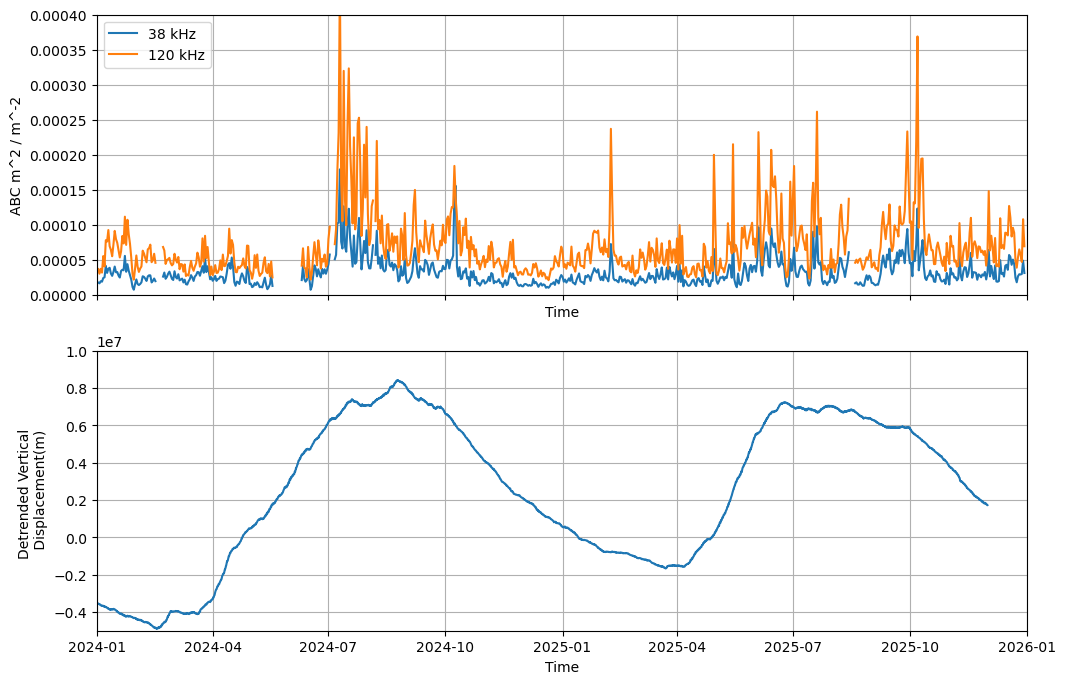

: 

In [ ]:
import matplotlib.pyplot as plt


# Zoom to a date range
start_zoom = datetime(2024, 1, 1)
end_zoom = datetime(2026, 1, 1)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), sharex=True)

axes[0].plot(time, ABC_38[1,:])  # Plot the second column of CM_38 against time
axes[0].plot(time, ABC_120[1,:])  # Plot the second column of CM_120 against time
axes[0].set_xlabel('Time')
axes[0].set_ylabel('ABC m^2 / m^-2')
axes[0].set_xlim(start_zoom, end_zoom)
axes[0].set_ylim(0, 4*10**-4)
axes[0].legend(['38 kHz', '120 kHz'])
axes[0].grid(True)

if csv_filename == 'ADCP300kHz_FolgerDeep_2014_2026_verticalFlowSpeed.csv':
    axes[1].plot(verticalDisplacement_time, verticalFlow_midColumn)  
    axes[1].set_ylabel('Detrended Vertical \n Flow (m / day)')
    #axes[1].set_ylim(-0.5e7, 1e7)   

elif csv_filename == 'ADCP300kH_FolgerDeep_2014_2026_verticalDisplacement.csv':
    axes[1].plot(verticalDisplacement_time, verticalDisplacement_midColumn_detrend)  # Plot the first column of CM_38 against time
    # axes[1].plot(verticalDisplacement_time, verticalDisplacement_upperColumn_detrend)  # Plot the first column of CM_38 against time
    #axes[2].plot(verticalDisplacement_time, verticalDisplacement_midColumn)  # Plot the first column of CM_38 against time
    axes[1].set_ylabel('Detrended Vertical \n Displacement(m)')
    # axes[2].set_ylim(5e7, 7e7)    
    axes[1].set_ylim(-0.5e7, 1e7)   

axes[1].set_xlabel('Time')          
axes[1].set_xlim(start_zoom, end_zoom)
# axes[1].legend(['mid-column (52.9 m)', 'upper-column (16.9 m)'])
axes[1].grid(True)

plt.show()

### PArt 2: 
### Look at the Spring Bloom at Strait of Georgia East

## TODO: Get CTD and O2 data from Oceans

In [ ]:
import h5py
import numpy as np
import pandas as pd

#To convert MATLAB datenum to python datetime
from datetime import datetime, timedelta

#Look at Strait of Georgia East data
filename = 'SoGEast_20140101_20260101_averaged.mat'

#Look at data from Folger Deep
#filename = 'FolgerDeep_20140101_20260101_averaged.mat'

with h5py.File(filename,'r') as f:
    #Import hourly averaged data
    data = f['data_avg']['hr_01']

    #Load time variable and convert to datetime
    time_MATLAB = np.array(data['time']).squeeze()    
    # The offset for the Unix epoch (1970-01-01) in MATLAB datenum format is 719529
    unix_epoch_offset_matlab = 719529
    time = pd.to_datetime(time_MATLAB - unix_epoch_offset_matlab, unit='D')

    #Get the Time-series data for the 38 kHz channel
    ch_38 = data['ch_38kHz']
    CM_38 = np.array(ch_38['CM'])
    ABC_38 = np.array(ch_38['ABC'])

    #Get the Time-series data for the 120 kHz channel
    ch_120 = data['ch_120kHz']
    CM_120 = np.array(ch_120['CM'])
    ABC_120 = np.array(ch_120['ABC'])

    #Get the device temperature too (if it exists.  Will exist for Saanich and SoG East, but not Folger Deep)
    temperature = np.array(data['temperature'])



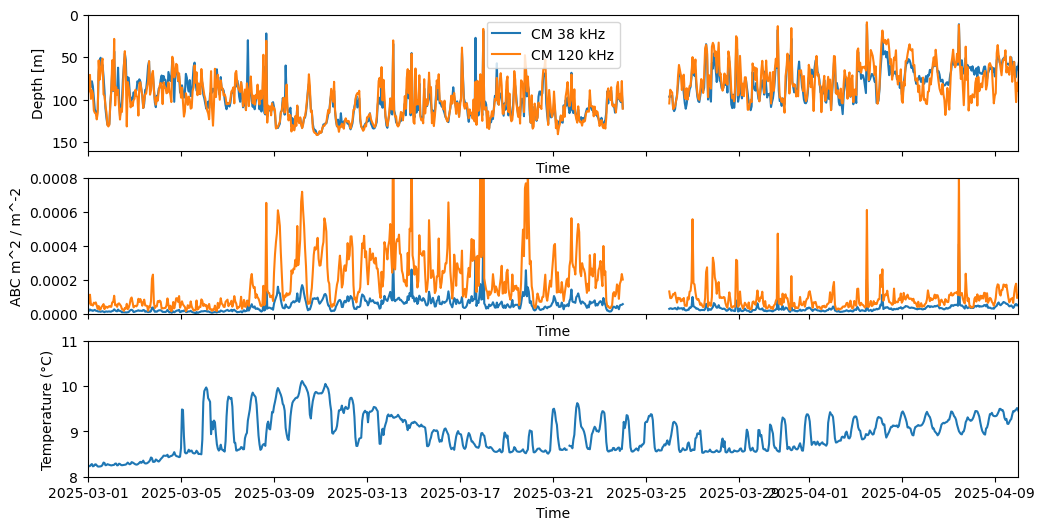

In [ ]:
import matplotlib.pyplot as plt

# Lets plot CM, ABC, and Temperature

#Lets look at the Spring Bloom in the Strait of Georgia in 2025

# Zoom to a date range
start_zoom = datetime(2025, 3, 1)
end_zoom = datetime(2025, 4, 10)

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 6), sharex=True)

axes[0].plot(time, CM_38[0,:])  # Plot the first column of CM_38 against time
axes[0].plot(time, CM_120[0,:])  # Plot the first column of CM_120 against time
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Depth [m]')
axes[0].set_xlim(start_zoom, end_zoom)
axes[0].set_ylim(0, 160)
axes[0].invert_yaxis()
axes[0].legend(['CM 38 kHz', 'CM 120 kHz'])

axes[1].plot(time, ABC_38[0,:])  # Plot the first column of CM_38 against time
axes[1].plot(time, ABC_120[0,:])  # Plot the first column of CM_120 against time
axes[1].set_xlabel('Time')
axes[1].set_ylabel('ABC m^2 / m^-2')
axes[1].set_xlim(start_zoom, end_zoom)
axes[1].set_ylim(0, 8*10**-4)

axes[2].plot(time, temperature[0,:])  # Plot the first column of CM_38 against time
axes[2].set_xlabel('Time')          
axes[2].set_ylabel('Temperature (°C)')
axes[2].set_xlim(start_zoom, end_zoom)
axes[2].set_ylim(8, 11)

plt.show()

### PART 3:

### Load CM data, zoom to an interesting month
### Load The MVBS data and plot the CM data on top
### Point out an especially interesting few hours and load the AZFP data from Oceans 3.0
FOR
### SoG East during the bloom
### OR Saanich Inlet with the poster example


In [ ]:
#Request data from Oceans 3.0